In [1]:
import os, random
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.spatial import distance
# from torchsummary import summary
import wandb
from lstm_class import LSTM_Single_Layer

In [2]:
def check_prox(a, b, threshhold):
    """returns 1 if the proximity between two points is <= a defined threshold
    else, returns 0"""
    #get distance from a to b
    delta_x = np.abs(a[0] - b[0])
    delta_y = np.abs(a[1] - b[1])
    dist = np.sqrt(np.square(delta_x) + np.square(delta_y))

    #if dist <= threshold, 1 else 0
    if(dist <= threshhold):
        return 1
    else:
        return 0

In [3]:
def log(epoch, step, loss, real_x, real_y, pred_x, pred_y, map):
    
    # Create path plots
    real, ax1 = plt.subplots()
    fake, ax2 = plt.subplots()
    ax1.imshow(map)
    ax2.imshow(map)
    ax1.plot(real_x, real_y, 'ro-', ms=4) # create plot of real path
    ax2.plot(pred_x, pred_y, 'ro-', ms=4) # create plot of NN output

    wandb.log({
        'epoch': epoch,
        'step': step,
        'loss': loss,
        'real': real,
        'fake': fake
    })
    real.clear()
    fake.clear()
    plt.close('all')

In [4]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, gen_dir, transform=None, shape = (100,100), device='cpu', stop_after=500):
        self.device = device
        self.maps_and_paths = []

        num_maps = 0
        for directory in tqdm(os.listdir(gen_dir)):
            num_maps += 1
            dir_path = os.path.join(gen_dir, directory)
            sequence = []

            # open map file:
            with open(f"{dir_path}/{directory}.txt", 'r') as f:
                self.flat_map = np.loadtxt(f)
                self.map = np.asarray(self.flat_map, dtype=np.float32).reshape(shape[0],shape[1])

            # add map to sequence array:
            sequence.append(torch.tensor(self.map))

            path_dir = f"{dir_path}/paths/"
            num_paths = 0
            for filename in os.listdir(path_dir):
                num_paths += 1
                with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                    path_points_list = [] # a list to hold each point in a path
                    self.flat_path = np.loadtxt(f) # load in the flat path from file
                    self.path = np.asarray(self.flat_path, dtype=np.float32).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                    for point in self.path:
                        x = point[0]
                        y = point[1]
                        this_point = [x, y]
                        path_points_list.append(this_point)

                sequence.append(torch.tensor(path_points_list, dtype=torch.float)[:, :])
                
            self.maps_and_paths.append(sequence)

            if num_maps == stop_after:
                break
        
        self.transform = transform
        print("Done!")

    def __len__(self):
        return len(self.maps_and_paths)

    def __getitem__(self, idx):
        x = self.maps_and_paths[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model saving interval
SAVE_LEN = 5000

# wandb parameters
RECORD_METRICS = True
STEP_LEN = 500
# NUM_LAYERS = 1      # !!!!!*** if you want to actually change this you need to do it manually ****!!!!!

# training parameters
BATCH_SIZE = 1      # needs to be 1 since all paths are different lengths (can try padding with zeros too)
LR = 0.00001
NUM_EPOCHS = 1
DROPOUT = 1         #Dropout (yes=1 or no=0)
DROPOUT_P = 0.4     # what % of nodes to drop out (usually 0.2 to 0.5)


In [6]:

# dataset info
DATASET = 'random_30_density_large'
SUBSET = 'train'
MAP_SHAPE = (64,64)
train_dataset = PathsDataset(gen_dir = f"./env/{DATASET}/{SUBSET}/", shape = MAP_SHAPE, transform=None, device=device, stop_after=1000)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# encoder info
ENCODER_PATH = f"checkpoints/encoder/"
DECODER_PATH = f"checkpoints/decoder/"
LOAD_EPOCH = 101

SAVE_PATH = f"checkpoints/lstm/"

  1%|          | 9/1000 [00:02<05:06,  3.23it/s]

Done!


In [7]:
GROUP = ''

CONFIG = dict(
    dataset = DATASET,
    subset = SUBSET,

    batch_size = BATCH_SIZE,
    learning_rate = LR,
    dropout = DROPOUT,
    dropout_p = DROPOUT_P,
    # num_layers = NUM_LAYERS, 
    model_name = "LSTM_single_layer"
)

if RECORD_METRICS:
    run = wandb.init(project='LSTM', entity='aicv-lab', config=CONFIG, group=GROUP)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sploeger (aicv-lab). Use `wandb login --relogin` to force relogin


In [8]:
#create a folder for runs if it does not exist
if not os.path.exists(f'./checkpoints/lstm/{run.name}'):
    os.makedirs(f'./checkpoints/lstm/{run.name}')

In [9]:
class Encoder(nn.Module):
    """define encoder class that is used to encode maps
    Note: the encoder must be pre-trained using 'convolutional-auto-encoder.ipynb'"""
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),     
            nn.Conv2d(64, 128, 7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [10]:
def save_lstm(this_lstm, opt, loss, e, step, name):
    torch.save({
            'epoch': e,
            'step': step, 
            'model_state_dict': this_lstm.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss[len(loss)-1],
            'dropout': DROPOUT,
            'dropout_p': DROPOUT_P,
}, f"{SAVE_PATH}/{name}/step-{step}-epoch-{e}.tar")

In [11]:
# class Decoder(nn.Module):
"""decoder is not used in LSTM"""
#     def __init__(self):
#         super().__init__()

#         self.unflatten = nn.Unflatten(dim=1, 
#         unflattened_size=(128, 1, 1))

#         self.decoder_conv = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 7, 
#             stride=2, padding=0, output_padding=0),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, 5,
#             stride=2, padding=1, output_padding=0),
#             nn.BatchNorm2d(32),
#             nn.ConvTranspose2d(32, 16, 5, 
#             stride=2, padding=1, output_padding=0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 1, 5, 
#             stride=2, padding=1, output_padding=1)
#         )
        
#     def forward(self, x):
#         x = self.unflatten(x)
#         x = self.decoder_conv(x)
#         x = torch.sigmoid(x)
#         return x

'decoder is not used in LSTM'

In [12]:
# create a new encoder
encoder = Encoder()
# decoder = Decoder()

In [13]:
""" loads encoder checkpoint from file"""
checkpoint = torch.load(f'{ENCODER_PATH}epoch-{LOAD_EPOCH}.tar')
encoder.load_state_dict(checkpoint['model_state_dict'])

# checkpoint = torch.load(f'{DECODER_PATH}epoch-{LOAD_EPOCH}.tar')
# decoder.load_state_dict(checkpoint['model_state_dict'])

encoder.to(device)
# decoder.to(device)

encoder.eval()
# decoder.eval()

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [14]:
# creating empty data arrays:
maps = []
train_target_paths = []
train_input_paths = []
train_goal_points = []

for data in train_dataset:

    # add current map to 'maps' array:
    maps.append(data[0].to(device))                         # data[0] will be a map (just how dataloader works)

    # creating empty arrays for current maps' path data:
    curr_map_target_paths = []
    curr_map_input_paths = []
    curr_map_goal_points = torch.Tensor()

    # iterating through each path associated with current map:
    for path in data[1:]:                                   # data[1:] will be an array of paths associated with the data[0] map
        input_path = path[:-1]  # all points except last
        target_path = path[1:]  # all points except first
        goal_point = path[len(path)-1].unsqueeze(0)     # array containing goal point information

        # add input, target, and goal point information to respective arrays:
        curr_map_target_paths.append(torch.Tensor(target_path).to(device))
        curr_map_input_paths.append(torch.Tensor(input_path).to(device))
        curr_map_goal_points = torch.cat((curr_map_goal_points, goal_point), 0)

    # add all path information associated with current map:
    train_target_paths.append(curr_map_target_paths)
    train_input_paths.append(curr_map_input_paths)
    train_goal_points.append(curr_map_goal_points.to(device))

In [15]:
# print(len(train_input_paths))
# print(len(train_target_paths))
# print(len(train_goal_points))

# print(len(test_input_paths))

# map_num = 1

# print(f"path num: {len(train_input_paths[map_num])}")
# # print(train_input_paths[map_num])
# print(len(train_target_paths[map_num]))
# print(len(train_goal_points[map_num]))

In [16]:
# map = maps[0]
# # print(map.device)
# plt.imshow(map.cpu())
# plt.show()

# map_4d = map.unsqueeze(0).unsqueeze(0)
# encoded_map = encoder(map_4d)#.squeeze()
# print(encoded_map.shape)

# # decoded_map = decoder(encoded_map)
# # new_map_2d = decoded_map.squeeze()

# # plt.imshow(new_map_2d.cpu().detach().numpy())
# # plt.show()

LSTM_Single_Layer(
  (lstm_map): LSTMCell(128, 120)
  (lstm_points): LSTMCell(4, 120)
  (lstm1): LSTMCell(240, 120)
  (fc): Linear(in_features=120, out_features=2, bias=True)
  (do): Dropout(p=0.4, inplace=False)
)


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0
Map 0/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

Map 1/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

Map 2/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

Map 3/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

Map 4/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

Map 5/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

Map 6/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

Map 7/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

Map 8/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

Map 9/10


Training paths for current map:   0%|          | 0/1000 [00:00<?, ?it/s]

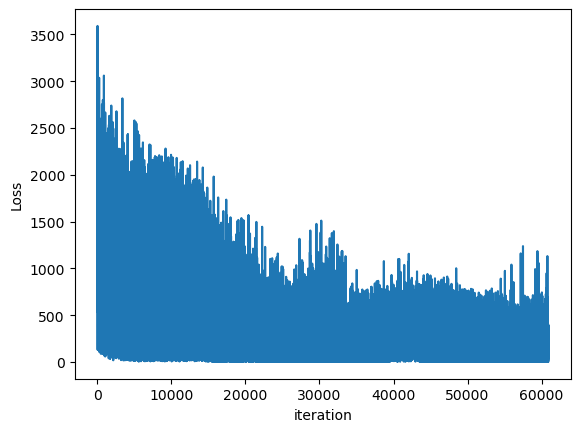

In [17]:
this_lstm = LSTM_Single_Layer(device=device, dropout=DROPOUT, dropout_p=DROPOUT_P)
# print summary
print(this_lstm)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.Adam(this_lstm.parameters(), lr=LR)
for e in tqdm_notebook(range(NUM_EPOCHS), desc = f'Epochs'):

  print(f'epoch: {e}')
  this_lstm.hidden_states = this_lstm.init_hidden() # re-initialize hidden and cell states for each epoch

  for map_num in range(len(maps)):                                          # go through each map
    print(f'Map {map_num}/{len(maps)}')
    encoded_map = encoder(maps[map_num].unsqueeze(0).unsqueeze(0))

    for path_num in tqdm_notebook(range(len(train_input_paths[map_num])), desc = f'Training paths for current map'):                # go through each path
      
      if RECORD_METRICS:
        path_loss = []
        path_pred = []
      
      for point_num in range(len(train_input_paths[map_num][path_num])):   # go through each point
        pred = this_lstm(train_goal_points[map_num][path_num], train_input_paths[map_num][path_num][point_num], encoded_map)[0].squeeze()
        
        if RECORD_METRICS:
          path_pred.append(pred.cpu().detach())
        
        err = criterion(pred, train_target_paths[map_num][path_num][point_num])
        opt.zero_grad()
        err.backward(retain_graph=True)
        opt.step()
        loss.append(err.item())

        if RECORD_METRICS:
          path_loss.append(err.item())

      # Log to WandB
      if RECORD_METRICS and path_num % STEP_LEN == 0:
        path_loss = np.mean(path_loss)

        # Convert items from path lists to ndarrays
        real_x = []
        real_y = []
        for item in train_target_paths[map_num][path_num].cpu().detach():
          real_x.append(item[0])
          real_y.append(item[1])

        pred_x = []
        pred_y = []
        for item in path_pred:
          pred_x.append(item[0])
          pred_y.append(item[1])

        log(e, run.step, path_loss, real_x, real_y, pred_x, pred_y, maps[map_num].cpu())
      if path_num % SAVE_LEN == 0:
        save_lstm(this_lstm, opt, loss, e, run.step, run.name)# save lstm every every SAVE_LEN paths

plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

In [18]:
run.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,██▄▅▁▂▃▁▂▁▁▂▃▂▁▂▂▂▂▁
step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch,0
loss,41.56312
step,19


In [19]:
save_lstm(this_lstm, opt, loss, e, run.step, run.name)# save lstm at end

In [20]:
SAVE_PATH = f"checkpoints/lstm/"

torch.save({
            'epoch': e,
            'model_state_dict': this_lstm.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss[len(loss)-1],
            'dropout': DROPOUT,
            'dropout_p': DROPOUT_P,
}, f"{SAVE_PATH}epoch-{e}.tar")

goal: [57.0, 51.0], pred: [23.923084259033203, 20.0660343170166]
goal: [57.0, 51.0], pred: [27.081989288330078, 23.10542106628418]
goal: [57.0, 51.0], pred: [25.875070571899414, 24.324846267700195]
goal: [57.0, 51.0], pred: [26.569753646850586, 25.642690658569336]
goal: [57.0, 51.0], pred: [25.90753936767578, 24.982465744018555]
goal: [57.0, 51.0], pred: [29.18841552734375, 27.644214630126953]
goal: [57.0, 51.0], pred: [25.115257263183594, 24.156686782836914]
goal: [57.0, 51.0], pred: [28.482454299926758, 27.00935173034668]
goal: [57.0, 51.0], pred: [29.135574340820312, 28.142017364501953]
goal: [57.0, 51.0], pred: [29.281597137451172, 28.97600746154785]
goal: [57.0, 51.0], pred: [25.826805114746094, 25.278549194335938]
goal: [57.0, 51.0], pred: [25.81787872314453, 23.715856552124023]
goal: [57.0, 51.0], pred: [27.15853500366211, 25.123260498046875]
goal: [57.0, 51.0], pred: [25.876258850097656, 24.419931411743164]
goal: [57.0, 51.0], pred: [24.61450958251953, 25.044946670532227]
goal:

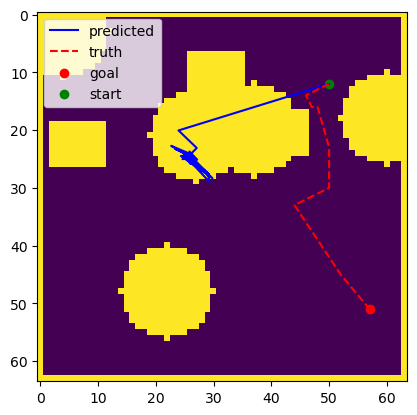

goal: [56.0, 57.0], pred: [27.598745346069336, 28.5025634765625]
goal: [56.0, 57.0], pred: [24.224279403686523, 24.1422176361084]
goal: [56.0, 57.0], pred: [27.5288028717041, 27.430526733398438]
goal: [56.0, 57.0], pred: [26.393394470214844, 26.589561462402344]
goal: [56.0, 57.0], pred: [25.79714012145996, 25.772050857543945]
goal: [56.0, 57.0], pred: [29.107738494873047, 27.80567169189453]
goal: [56.0, 57.0], pred: [27.674686431884766, 27.46194076538086]
goal: [56.0, 57.0], pred: [26.719932556152344, 26.188976287841797]
goal: [56.0, 57.0], pred: [28.45805549621582, 27.70836067199707]
goal: [56.0, 57.0], pred: [24.381153106689453, 24.563535690307617]
goal: [56.0, 57.0], pred: [24.616863250732422, 24.786035537719727]
goal: [56.0, 57.0], pred: [25.774112701416016, 24.4204158782959]
goal: [56.0, 57.0], pred: [28.936885833740234, 26.29964256286621]
goal: [56.0, 57.0], pred: [25.02092170715332, 23.86249351501465]
goal: [56.0, 57.0], pred: [26.5664119720459, 25.08819007873535]
goal: [56.0, 5

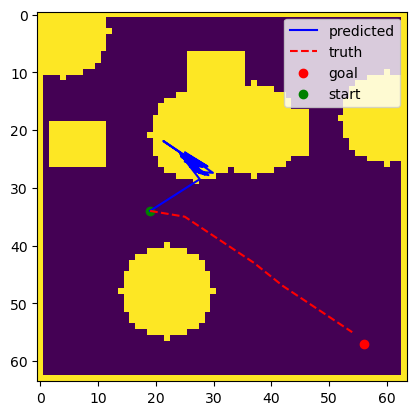

goal: [9.0, 42.0], pred: [26.56490707397461, 26.419160842895508]
goal: [9.0, 42.0], pred: [22.984901428222656, 22.49043846130371]
goal: [9.0, 42.0], pred: [25.655086517333984, 24.883485794067383]
goal: [9.0, 42.0], pred: [25.88333511352539, 24.96784019470215]
goal: [9.0, 42.0], pred: [23.3433837890625, 23.68549156188965]
goal: [9.0, 42.0], pred: [21.503742218017578, 21.711441040039062]
goal: [9.0, 42.0], pred: [23.603687286376953, 22.570913314819336]
goal: [9.0, 42.0], pred: [22.37895965576172, 23.607221603393555]
goal: [9.0, 42.0], pred: [23.191675186157227, 23.99921226501465]
goal: [9.0, 42.0], pred: [22.822216033935547, 22.7806396484375]
goal: [9.0, 42.0], pred: [23.142364501953125, 23.14866828918457]
goal: [9.0, 42.0], pred: [22.395225524902344, 23.469783782958984]
goal: [9.0, 42.0], pred: [24.777690887451172, 24.861783981323242]
goal: [9.0, 42.0], pred: [22.371131896972656, 23.542634963989258]
goal: [9.0, 42.0], pred: [20.00375747680664, 20.415281295776367]
goal: [9.0, 42.0], pred

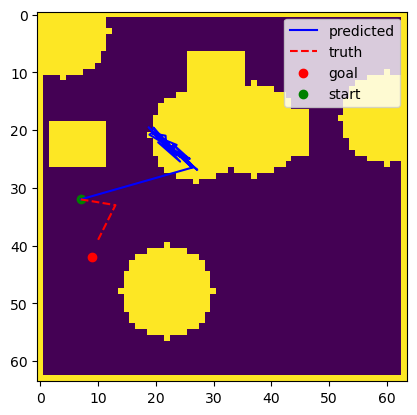

goal: [33.0, 49.0], pred: [24.157142639160156, 24.970523834228516]
goal: [33.0, 49.0], pred: [25.78240203857422, 25.81125831604004]
goal: [33.0, 49.0], pred: [27.924121856689453, 28.63798713684082]
goal: [33.0, 49.0], pred: [27.905498504638672, 28.493663787841797]
goal: [33.0, 49.0], pred: [21.705890655517578, 22.721641540527344]
goal: [33.0, 49.0], pred: [26.39229965209961, 25.745214462280273]
goal: [33.0, 49.0], pred: [20.065149307250977, 20.433197021484375]
goal: [33.0, 49.0], pred: [24.885459899902344, 24.310768127441406]
goal: [33.0, 49.0], pred: [22.11029624938965, 22.48652458190918]
goal: [33.0, 49.0], pred: [24.897825241088867, 25.390783309936523]
goal: [33.0, 49.0], pred: [21.81113624572754, 22.520051956176758]
goal: [33.0, 49.0], pred: [20.655223846435547, 21.632343292236328]
goal: [33.0, 49.0], pred: [20.982540130615234, 20.6800479888916]
goal: [33.0, 49.0], pred: [22.058887481689453, 21.291353225708008]
goal: [33.0, 49.0], pred: [22.278467178344727, 22.50562286376953]
goal:

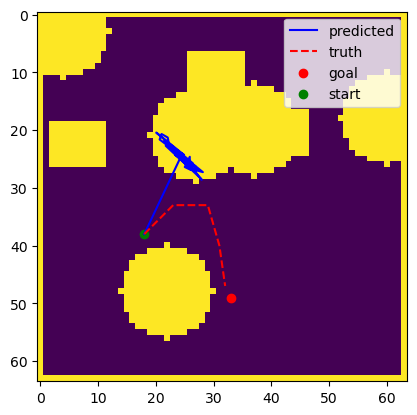

goal: [60.0, 60.0], pred: [23.972633361816406, 23.92888832092285]
goal: [60.0, 60.0], pred: [23.82930564880371, 23.597366333007812]
goal: [60.0, 60.0], pred: [27.608598709106445, 26.8432559967041]
goal: [60.0, 60.0], pred: [26.756587982177734, 26.234251022338867]
goal: [60.0, 60.0], pred: [28.679418563842773, 28.307870864868164]
goal: [60.0, 60.0], pred: [30.737960815429688, 31.074125289916992]
goal: [60.0, 60.0], pred: [28.07268524169922, 27.035791397094727]
goal: [60.0, 60.0], pred: [27.132617950439453, 26.26947593688965]
goal: [60.0, 60.0], pred: [26.47551727294922, 25.41959571838379]
goal: [60.0, 60.0], pred: [28.24626350402832, 28.092519760131836]
goal: [60.0, 60.0], pred: [28.23787498474121, 29.16758155822754]
goal: [60.0, 60.0], pred: [27.549625396728516, 27.30816078186035]
goal: [60.0, 60.0], pred: [26.705730438232422, 25.890012741088867]
goal: [60.0, 60.0], pred: [27.46757698059082, 25.51774024963379]
goal: [60.0, 60.0], pred: [25.702442169189453, 25.762834548950195]
goal: [60

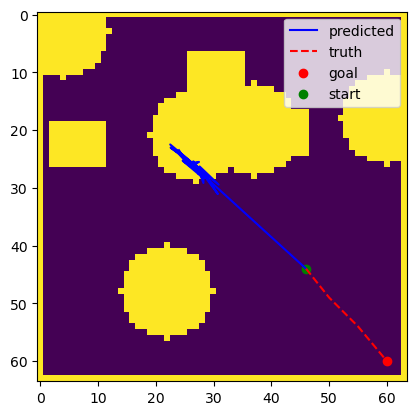

goal: [5.0, 33.0], pred: [29.713863372802734, 28.908361434936523]
goal: [5.0, 33.0], pred: [26.71853256225586, 26.823951721191406]
goal: [5.0, 33.0], pred: [25.47710418701172, 25.699466705322266]
goal: [5.0, 33.0], pred: [22.907249450683594, 22.176382064819336]
goal: [5.0, 33.0], pred: [20.48235321044922, 20.54665756225586]
goal: [5.0, 33.0], pred: [22.308670043945312, 21.653100967407227]
goal: [5.0, 33.0], pred: [21.788410186767578, 21.624345779418945]
goal: [5.0, 33.0], pred: [17.09893035888672, 16.244287490844727]
goal: [5.0, 33.0], pred: [18.869815826416016, 18.15968132019043]
goal: [5.0, 33.0], pred: [20.87173080444336, 20.30351448059082]
goal: [5.0, 33.0], pred: [19.274246215820312, 20.83841323852539]
goal: [5.0, 33.0], pred: [18.12285614013672, 18.198638916015625]
goal: [5.0, 33.0], pred: [21.032718658447266, 20.529006958007812]
goal: [5.0, 33.0], pred: [20.87256622314453, 20.07257652282715]
goal: [5.0, 33.0], pred: [21.382282257080078, 20.284902572631836]
goal: [5.0, 33.0], pre

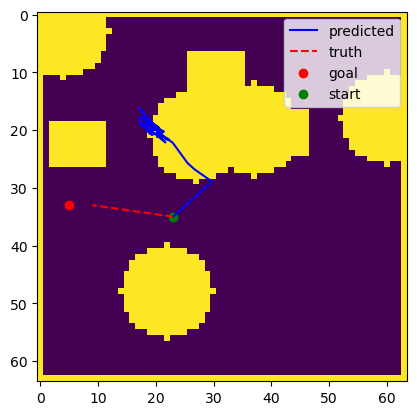

goal: [53.0, 9.0], pred: [20.858671188354492, 19.875595092773438]
goal: [53.0, 9.0], pred: [16.856473922729492, 16.010164260864258]
goal: [53.0, 9.0], pred: [20.867406845092773, 18.13347816467285]
goal: [53.0, 9.0], pred: [20.00106430053711, 16.766809463500977]
goal: [53.0, 9.0], pred: [21.940826416015625, 17.92234230041504]
goal: [53.0, 9.0], pred: [22.871673583984375, 19.97825813293457]
goal: [53.0, 9.0], pred: [23.75005531311035, 19.93035316467285]
goal: [53.0, 9.0], pred: [28.960975646972656, 23.786771774291992]
goal: [53.0, 9.0], pred: [28.525667190551758, 24.535402297973633]
goal: [53.0, 9.0], pred: [24.7091121673584, 21.801321029663086]
goal: [53.0, 9.0], pred: [27.65947914123535, 23.967315673828125]
goal: [53.0, 9.0], pred: [26.673049926757812, 22.97541618347168]
goal: [53.0, 9.0], pred: [24.849987030029297, 21.03127098083496]
goal: [53.0, 9.0], pred: [24.369274139404297, 20.126718521118164]
goal: [53.0, 9.0], pred: [30.589740753173828, 27.070810317993164]
goal: [53.0, 9.0], pr

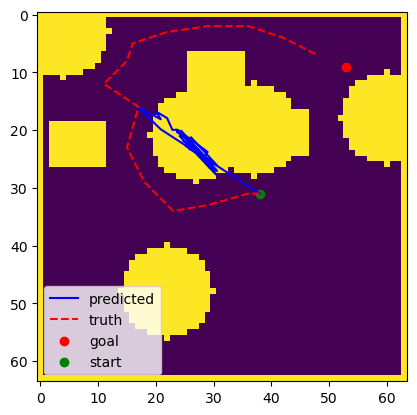

goal: [3.0, 35.0], pred: [23.24298095703125, 23.30710792541504]
goal: [3.0, 35.0], pred: [27.606332778930664, 25.82891845703125]
goal: [3.0, 35.0], pred: [26.393962860107422, 24.756349563598633]
goal: [3.0, 35.0], pred: [22.463993072509766, 22.531160354614258]
goal: [3.0, 35.0], pred: [23.735271453857422, 23.302021026611328]
goal: [3.0, 35.0], pred: [21.511138916015625, 22.228866577148438]
goal: [3.0, 35.0], pred: [23.695585250854492, 23.522939682006836]
goal: [3.0, 35.0], pred: [23.84417724609375, 23.41509437561035]
goal: [3.0, 35.0], pred: [22.595291137695312, 22.973100662231445]
goal: [3.0, 35.0], pred: [18.988004684448242, 19.50620460510254]
goal: [3.0, 35.0], pred: [15.918407440185547, 16.055330276489258]
goal: [3.0, 35.0], pred: [21.379180908203125, 21.41938018798828]
goal: [3.0, 35.0], pred: [19.693668365478516, 19.61817741394043]
goal: [3.0, 35.0], pred: [20.279582977294922, 20.123018264770508]
goal: [3.0, 35.0], pred: [21.360429763793945, 21.15766716003418]
goal: [3.0, 35.0], 

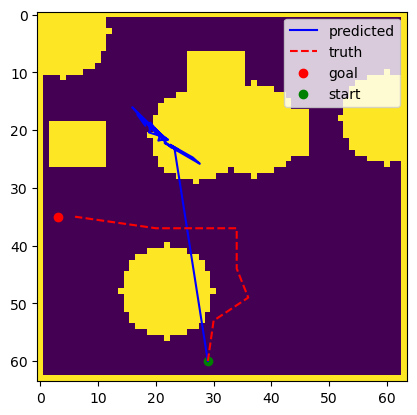

goal: [40.0, 34.0], pred: [23.597881317138672, 23.209341049194336]
goal: [40.0, 34.0], pred: [22.865312576293945, 23.35297393798828]
goal: [40.0, 34.0], pred: [25.290790557861328, 24.057048797607422]
goal: [40.0, 34.0], pred: [25.198522567749023, 23.751127243041992]
goal: [40.0, 34.0], pred: [23.88478660583496, 21.610910415649414]
goal: [40.0, 34.0], pred: [27.213720321655273, 25.49180793762207]
goal: [40.0, 34.0], pred: [23.11225128173828, 22.130756378173828]
goal: [40.0, 34.0], pred: [28.58112907409668, 26.406951904296875]
goal: [40.0, 34.0], pred: [20.430130004882812, 19.51545524597168]
goal: [40.0, 34.0], pred: [24.126079559326172, 22.87303352355957]
goal: [40.0, 34.0], pred: [23.43877410888672, 21.892593383789062]
goal: [40.0, 34.0], pred: [25.486244201660156, 24.445331573486328]
goal: [40.0, 34.0], pred: [25.801593780517578, 24.233264923095703]
goal: [40.0, 34.0], pred: [21.321788787841797, 20.2276554107666]
goal: [40.0, 34.0], pred: [27.37936019897461, 25.1724796295166]
goal: [4

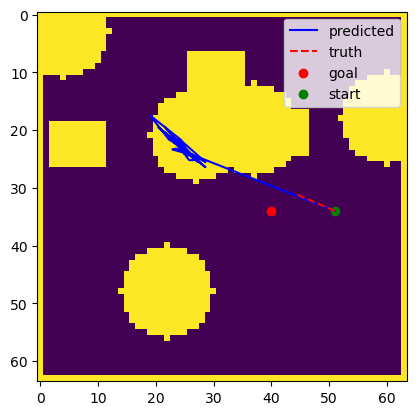

goal: [45.0, 47.0], pred: [23.266206741333008, 23.6251163482666]
goal: [45.0, 47.0], pred: [25.309267044067383, 25.012033462524414]
goal: [45.0, 47.0], pred: [23.531906127929688, 24.064847946166992]
goal: [45.0, 47.0], pred: [26.508075714111328, 24.47764015197754]
goal: [45.0, 47.0], pred: [27.694190979003906, 26.04995346069336]
goal: [45.0, 47.0], pred: [26.148601531982422, 25.453073501586914]
goal: [45.0, 47.0], pred: [27.91927719116211, 25.78206443786621]
goal: [45.0, 47.0], pred: [25.60364532470703, 24.601167678833008]
goal: [45.0, 47.0], pred: [25.331329345703125, 25.240476608276367]
goal: [45.0, 47.0], pred: [26.547550201416016, 26.34492301940918]
goal: [45.0, 47.0], pred: [25.792970657348633, 26.448286056518555]
goal: [45.0, 47.0], pred: [22.956539154052734, 22.08807373046875]
goal: [45.0, 47.0], pred: [24.811237335205078, 24.334182739257812]
goal: [45.0, 47.0], pred: [25.279138565063477, 23.163373947143555]
goal: [45.0, 47.0], pred: [23.795394897460938, 22.806428909301758]
goal

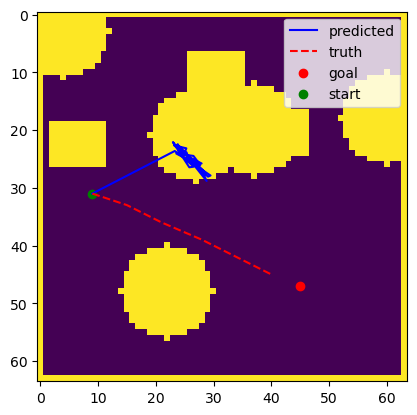

In [21]:
# Test performance on the training dataset

num_points = 30 # num points to predict for each path
maps_to_gen = 1
paths_to_gen = 10 # num training paths to plot

states = torch.zeros(1, this_lstm.hidden_d).to(this_lstm.device)

for map_idx in range(maps_to_gen):
    map = maps[map_idx]
    for path_idx in range(paths_to_gen):
        start_point = train_input_paths[map_idx][path_idx][0]
        generated_pts = []
        with torch.no_grad():
            
            # add start point:
            generated_pts.append(start_point.cpu().detach().numpy().tolist())
            prev_pred = start_point

            # predict other points:
            for i in range(num_points):
                pred = this_lstm(train_goal_points[map_idx][path_idx], prev_pred, encoded_map).squeeze()
                prev_pred = pred
                generated_pts.append(pred.cpu().detach().numpy().tolist())
                print(f'goal: {train_goal_points[map_idx][path_idx].cpu().detach().numpy().tolist()}, pred: {pred.cpu().detach().numpy().tolist()}')
                if check_prox(train_goal_points[map_idx][path_idx].cpu().detach().numpy().tolist(), pred.cpu().detach().numpy().tolist(), 3):  # stop predicting if close to goal
                    print("threshhold met, exiting")
                    break

        xs = []
        ys = []

        for x,y in generated_pts:
            xs.append(x)
            ys.append(y)

        plt.imshow(map.cpu())
        # plt.plot(xs, ys, color='k', label = "input")
        plt.plot(xs, ys, color='b', label = "predicted")
        plt.plot(train_input_paths[map_idx][path_idx][:,0].cpu(), train_input_paths[map_idx][path_idx][:,1].cpu(), color='r', label = "truth", linestyle='dashed')
        plt.scatter(train_goal_points[map_idx][path_idx][0].cpu(), train_goal_points[map_idx][path_idx][1].cpu(), c='r', label='goal')
        plt.scatter(start_point[0].cpu(), start_point[1].cpu(), c='g', label='start')
        plt.legend()
        plt.show()

In [22]:
# Test performance on unseen/eval maps

# flat_map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2)                                                   # load in the flat path from file
# flat_map = np.loadtxt(f"./env/100_maps_20p_coverage/{SUBSET}/map_6/map_2.txt")
flat_map = np.loadtxt(f"./env/{DATASET}/eval/map_0/map_0.txt")
map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(MAP_SHAPE[0], MAP_SHAPE[1])).to(device, dtype=torch.float)     # unflatten the map from the file
map_4d = map.unsqueeze(0).unsqueeze(0)
encoded_map = encoder(map_4d)

# testing to see if it follows new paths:
non_obs_coords = np.transpose(torch.flipud(np.argwhere(map.cpu()==0)))
# print(non_obs_coords)

start_points_list = []
coords_list = []

num_points = 30 # num points to predict for each path
paths_to_gen = 20 # num paths to generate

states = torch.zeros(1, this_lstm.hidden_d).to(this_lstm.device)

for x in range(paths_to_gen):
    start_point = random.choice(non_obs_coords).float().to(device)
    goal_point = random.choice(non_obs_coords).float().to(device)

    points = []
    with torch.no_grad():
        pred = start_point
        points.append(pred.cpu().detach().numpy().tolist())
        for point in range(num_points):
            pred = this_lstm(goal_point, pred, encoded_map).squeeze()
            points.append(pred.cpu().detach().numpy().tolist())
            if check_prox(goal_point.cpu().detach().numpy().tolist(), pred.cpu().detach().numpy().tolist(), 3): # stop predicting if close to goal
                print("reached goal, exiting")
                break

    xs = []
    ys = []
    for x,y in points:
        xs.append(x)
        ys.append(y)

    plt.imshow(map.cpu())
    plt.plot(xs, ys, color='b', label = "predicted")
    plt.scatter(goal_point[0].cpu(), goal_point[1].cpu())
    plt.scatter(start_point[0].cpu(), start_point[1].cpu())
    plt.legend()
    plt.show()

OSError: ./env/random_30_density_large/eval/map_0/map_0.txt not found.